In [44]:
from planckmc.track_generation import halo_model
from planckmc.track_generation import make_tracks
from planckmc.detector_characteristics import DETECTOR_CHARACTERISTICS
from planckmc.response import sensor_response, RESPONSE_DICT
from planckmc.config import CONFIG
import planckanalysis.integral_transform as pint

import numpy as np
from numba import njit, jit
from tqdm import tqdm
import numericalunits as nu
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from random import randrange, uniform
import json

%matplotlib inline
import matplotlib # plotting libraries
from matplotlib import animation, rc, cm
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.mplot3d import Axes3D

#%pdb

In [45]:
#Essential Cell: SIMULATION ACCELERATION
#Creates track and sensor accelerations (without noise) & developes varibale name standards

#Custom Track: 7.5 (units) in length; comment the next two lines
#vel, entry_vecs, exit_vecs, t_entry, t_exit = np.array([257500.]), np.array([[2.10893786], [3.19662096], [3.51766905]]), np.array([[-3.94093443], [ 3.26567685], [-0.91890723]]), np.array([0.]), np.array([2.91362915e-05])

#Randomized Track:
vel = halo_model.generate_vel_array(n_vels=1)
entry_vecs, exit_vecs, t_entry, t_exit = make_tracks.generate_tracks(vel, np.zeros(vel.shape))

track=0

sensors = tuple(DETECTOR_CHARACTERISTICS.keys())

# Make sure the linear response in RESPONSE_DICT (simulation) is the same as the one used in the analysis (Run Response_update)
lin_resp = RESPONSE_DICT[sensors[0]]['linear_response']
lin_resp_len = len(lin_resp)
floor_val = ((lin_resp_len - (((t_exit - t_entry) * 10**7) + 2)) // 2) + 1

if floor_val > 1:
    n_pad_strt = randrange(floor_val, floor_val + 50) # + 200
    n_pad_end = randrange(floor_val, floor_val + 50)
else:
    floor_val = 1
    n_pad_strt = randrange(floor_val, floor_val + 50)
    n_pad_end = randrange(floor_val, floor_val + 50)

# Acceleration without noise:
out = make_tracks.generate_acceleration_dict(entry_vecs, exit_vecs, t_entry, t_exit, {'M':1e8, 'G':6.67e-11}, strt_padding=n_pad_strt, end_padding=n_pad_end)

accels = []
sensors_pos = []
cnt = 0

for key in out[track]:
    if key not in ['time', 'particle_location']:
        accels.append(out[track][sensors[cnt]])
        sensors_pos.append(DETECTOR_CHARACTERISTICS[key]['position'])
        cnt += 1

# Check: Helpful for when n_pad_strt & n_pad_end vary to check for sizes of arrays
sensor_response(sensors[0], out[0][sensors[0]]), np.linalg.norm(exit_vecs - entry_vecs), n_pad_strt, n_pad_end, len(out[track]['time'])

(array([[32768, 32768, 32768],
        [32768, 32768, 32768],
        [32768, 32768, 32767],
        ...,
        [32768, 32767, 32767],
        [32768, 32767, 32767],
        [32768, 32767, 32767]], dtype=int64),
 7.690856172227313,
 326,
 287,
 886)

In [46]:
# Essential cell: NOISY SIMULATION ACCELERATIONS
# Generates associated adc values (with added noise) to accelerations
# and Takes adc values and returns associated accelerations with noise

accels_noise = []
x = sensor_response(sensors[0], out[track][sensors[0]])
full_data_1 = np.array([[0] * 3 for i in range(x.shape[0])])
full_data = np.array([full_data_1 for j in range(len(sensors))])
tm_vals = []

for sensrs in range(0,len(sensors)):
    x = sensor_response(sensors[sensrs], out[track][sensors[sensrs]], response_dict=RESPONSE_DICT)
    for tms in range(0,x.shape[0]):
        for dim in range(0,len(x[tms])):
            # adc with noise
            full_data[sensrs][tms][dim] = x[tms][dim]

m = np.array(RESPONSE_DICT[sensors[0]]['signal_transfer_response'])

# Acceleration with noise
accels_w_noise = pint.adc_readout_to_accel(full_data, np.concatenate([[-1], m[:-1]+np.diff(m)/2, [1]]))
#accels_w_noise = pint.adc_readout_to_accel(full_data, pint.generate_adc_lookup_table(m))

for sensrs2 in range(0,len(sensors)):
    accels_noise.append(accels_w_noise[sensrs2])

In [47]:
# Essential Cell: Analysis Parameter Definitions
# Defines the padding parameters, Displays roughly how many samples will run in transform, Defines the analysis parameters

# As defined above, the padding is infused with the accels and if wanted removed must be removed with entire consideration index-equivalent data
# Order of values in accels: padding -> accels -> padding
# Order of values in accels_noise: padding -> accels -> padding -> all of the convolution result

time = out[track]['time']-out[track]['time'][0]
time_ns = np.linspace(0, (len(accels_noise[0]) - 1) * int(CONFIG['Track Generation']['Timestep']), len(accels_noise[0])) # not to be passed into transform!!


#pad_setting = True
pad_setting = False

if pad_setting == False:
    # Acceleration Settings
    tm_steps = len(time) - n_pad_strt - n_pad_end
    tmstep_strt = n_pad_strt - 1
    tmstep_end = len(time) - n_pad_end - 1

else:
    # Acceleration Settings
    tm_steps = 50
    tmstep_strt = 0
    tmstep_end = len(time) - 1
    

rn_step_indctr = []
rn_step_indctr_ns = []
for rn_stps in range(tmstep_strt, tmstep_end, tm_steps):
    rn_step_indctr.append(rn_stps)
print(len(rn_step_indctr), tm_steps, tmstep_strt, tmstep_end)
        
analysis_parameter = []

# BELOW HERE: UNCOMMENT the analysis parameter(s) wanted for the analysis (Group of lines at a time) and define padding above correctly
##########################################################################################################################################

## Time analysis; requires padding above
#alphas = pint.Time_Analysis_alphas(vel, entry_vecs, exit_vecs)
#analysis_parameter.append('Time')

# If padding is removed for any of the two parameter analyses below, a truth value shift will occur in the noise analysis due to the convultion
# that makes the data
####################
## Velocity anlysis; if without padding then only velocity analysis, if with padding then two parameter analysis in time and velocity
alphas = pint.Velocity_Analysis_alphas(entry_vecs, exit_vecs, n_pad_strt, n_pad_end)
analysis_parameter.append('Velocity')

####################
## Spatial Theta analysis; if without padding and vel_spatial = vel then only spatial, if without padding and vel_spatial = centers of velocity_bin then
##                         spatial and velocity, if with padding and vel_spatial = vel then spatial and time, and if with padding and
##                         vel_spatial = centers of velocity_bin then spatial, time, and velocity

# vel_spatial = vel
## or
# velocity_bins = np.linspace(1e5, 7e5, 250)
# vel_spatial = velocity_bins[:-1] + np.diff(velocity_bins) / 2

# alphas, theta_cos_val = pint.Theta_Analysis_alphas(vel_spatial, entry_vecs, exit_vecs, n_pad_strt, n_pad_end, radius = float(CONFIG['Track Generation']['BoundingSphereRadius']))
# analysis_parameter.append('Theta_Space')

1 273 325 598


In [48]:
def transform_operation(time, tm_steps, tmstep_strt, tmstep_end, accels, alphas, sensors_pos, lin_resp):
    timestep_indices = np.array(range(tmstep_strt, tmstep_end, tm_steps))
    timesteps = time[timestep_indices]

    transformed_data = pint.transform(time/1e9, accels, timesteps/1e9, timestep_indices, np.array(alphas), sensors_pos, lin_resp)
    return transformed_data

In [49]:
def transform_operation_noise(time, tm_steps, tmstep_strt, tmstep_end, accels_noise, alphas, sensors_pos, lin_resp):
    timestep_indices = np.array(range(tmstep_strt, tmstep_end, tm_steps))
    timesteps = time[timestep_indices]
    
    transformed_data = pint.transform(time/1e9, accels_noise, timesteps/1e9, timestep_indices, np.array(alphas), sensors_pos, lin_resp)
    return transformed_data

In [50]:
# Necessary: Analysis
# Runs integral transform given the times, accelerations, alphas, and sensor positions
# Transform gives back S, Snorm, and the two four-vectors (x,y,z,t) for all the entry and exit points in the analysis

if tm_steps == len(time) and (tmstep_strt != n_pad_strt - 1 or tmstep_end != len(time) - n_pad_end):
    raise ValueError("You are only analyzing 1 time step, but you also are considering the padding. Please input correct values")
else:
    transformed_data = transform_operation(time, tm_steps, tmstep_strt, tmstep_end, accels, alphas, sensors_pos, [1])

100%|██████████| 1/1 [00:31<00:00, 31.42s/it]


In [51]:
# Necessary: Analysis W/ Noise
# Runs integral transform given the times, accelerations with noise, alphas, and sensor positions
# Transform has the same format as the cell above

if tm_steps == len(time) and (tmstep_strt != n_pad_strt - 1 or tmstep_end != len(time) - n_pad_end):
    raise ValueError("You are only analyzing 1 time step, but you also are considering the padding. Please input correct values")
else:
    transformed_data_noise = transform_operation_noise(time, tm_steps, tmstep_strt, tmstep_end, accels_noise, alphas, sensors_pos, lin_resp)

100%|██████████| 1/1 [00:37<00:00, 37.97s/it]


In [52]:
# Shows the result of transform
transformed_data

array([(0.33710146, 0.00060197, 1.89751939, -0.14977049, -4.83911035, 3.25e-05, -4.80636902, -1.48656642, -1.31489052, 1.08492984e-04, 560),
       (0.34363852, 0.00061364, 1.89751939, -0.14977049, -4.83911035, 3.25e-05, -4.80636902, -1.48656642, -1.31489052, 1.06725705e-04, 560),
       (0.35030168, 0.00062554, 1.89751939, -0.14977049, -4.83911035, 3.25e-05, -4.80636902, -1.48656642, -1.31489052, 1.05038757e-04, 560),
       (0.35708284, 0.00063765, 1.89751939, -0.14977049, -4.83911035, 3.25e-05, -4.80636902, -1.48656642, -1.31489052, 1.03426785e-04, 560),
       (0.36399336, 0.00064999, 1.89751939, -0.14977049, -4.83911035, 3.25e-05, -4.80636902, -1.48656642, -1.31489052, 1.01884898e-04, 560),
       (0.37104722, 0.00066258, 1.89751939, -0.14977049, -4.83911035, 3.25e-05, -4.80636902, -1.48656642, -1.31489052, 1.00408624e-04, 560),
       (0.37825378, 0.00067545, 1.89751939, -0.14977049, -4.83911035, 3.25e-05, -4.80636902, -1.48656642, -1.31489052, 9.89938607e-05, 560),
       (0.385

In [53]:
# Shows the track associated with the largest Snorm (and S) value
transformed_data[np.argmax(transformed_data['S_norm'])]

(9.51445702, 0.03485149, 1.89751939, -0.14977049, -4.83911035, 3.25e-05, -4.80636902, -1.48656642, -1.31489052, 5.97795326e-05, 273)

In [54]:
# Format: variable = np.array(transformed_data['variable_name'])

Snorm_data_plt = np.array(transformed_data['S_norm'])
S_data_plt = np.array(transformed_data['S'])

# Calculate variable from the standard varaibles of transform if necessary (e.g. theta from the cartesian coordinates)

tm_strt_plt = np.array(transformed_data['alpha0_t'])
tm_end_plt = np.array(transformed_data['alpha1_t'])
vel_plt = np.array(np.sqrt((transformed_data['alpha1_x'] - transformed_data['alpha0_x'])**2 +
                   (transformed_data['alpha1_y'] - transformed_data['alpha0_y'])**2 +
                   (transformed_data['alpha1_z'] - transformed_data['alpha0_z'])**2) / (transformed_data['alpha1_t'] - transformed_data['alpha0_t']))
if 'Theta_Space' in analysis_parameter:
    theta_cos_plt = theta_cos_val
    theta_plt = np.arccos(theta_cos_val)
else:
    theta_cos_plt = np.ones(len(S_data_plt))
    theta_plt = np.zeros(len(S_data_plt))

In [55]:
# Format: variable_noise = np.array(transformed_data_noise['variable_name'])

Snorm_data_plt_noise = np.array(transformed_data_noise['S_norm'])
S_data_plt_noise = np.array(transformed_data_noise['S'])

# Calculate variable from the standard varaibles of transform if necessary (e.g. theta from the cartesian coordinates)

tm_strt_plt_noise = np.array(transformed_data_noise['alpha0_t'])
tm_end_plt_noise = np.array(transformed_data_noise['alpha1_t'])
vel_plt_noise = np.array(np.sqrt((transformed_data_noise['alpha1_x'] - transformed_data_noise['alpha0_x'])**2 +
                                 (transformed_data_noise['alpha1_y'] - transformed_data_noise['alpha0_y'])**2 +
                                 (transformed_data_noise['alpha1_z'] - transformed_data_noise['alpha0_z'])**2) / (transformed_data_noise['alpha1_t'] - transformed_data_noise['alpha0_t']))
if 'Theta_Space' in analysis_parameter:
    theta_cos_plt_noise = theta_cos_val
    theta_plt_noise = np.arccos(theta_cos_val)
else:
    theta_cos_plt_noise = np.ones(len(S_data_plt_noise))
    theta_plt_noise = np.zeros(len(S_data_plt_noise))

In [56]:
# Full width Half Maximum Calculations

hf_max_S = np.max(transformed_data['S']) / 2
hf_max_Snorm = np.max(transformed_data['S_norm']) / 2

# Prominence (Maximum) Determination: Direct Assignment is possible; peak_prominences allows for calculations of correct left and right bases
prominence_info = peak_prominences(x=transformed_data['S_norm'], peaks=[np.argmax(transformed_data['S_norm'])])
prominence = [np.array([np.max(transformed_data['S_norm'])]), prominence_info[1], prominence_info[2]]

# Fwhm Calculation:
fwhm_data = peak_widths(x=transformed_data['S_norm'], peaks=[np.argmax(transformed_data['S_norm'])], rel_height=0.5, prominence_data=prominence)

# Output of function: widths of each each peak in samples (# of indices), width heights (height of where widths are determined),
#                     left interpolated position (left-most index of full-width), right interpolated position (Right-most index of full-width)


 # of indices =  32 , fwhm =  0.0
-----------------------------------------------------------


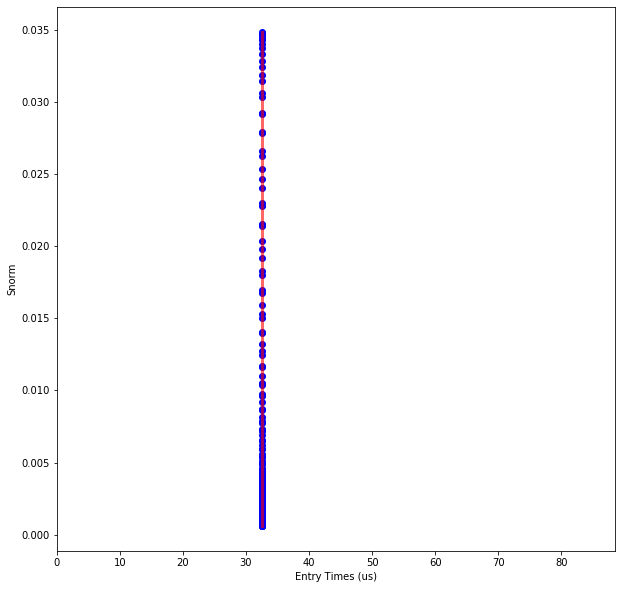

In [57]:
# Entry Time vs. S

X_Val1 = [(n_pad_strt - 1) / 10, (n_pad_strt - 1) / 10] # Actual Variable Value of Track
Y_Val1 = [min(Snorm_data_plt), max(Snorm_data_plt)] # If plotting S -> min & max of S_data_plt, If plotting Snorm -> min & max of Snorm_data_plt


fig1 = plt.figure(figsize=[10,10])
plt.plot(tm_strt_plt * 10**6, Snorm_data_plt, 'bo', alpha=1) # Input variable as the X axis & S or Snorm for the y axis
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.plot([tm_strt_plt[int(fwhm_data[2])] * 10**6, tm_strt_plt[int(fwhm_data[3])] * 10**6], [hf_max_Snorm, hf_max_Snorm], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(tm_strt_plt[int(fwhm_data[2])] - tm_strt_plt[int(fwhm_data[3])]) * 10**6)
print('-----------------------------------------------------------')

plt.xlim(t_entry * 10**6, t_entry * 10**6 + n_pad_strt / 10 + t_exit  * 10**6 + n_pad_end / 10) # Put ranges if necessary, careful of padding
plt.ylabel('Snorm')
plt.xlabel('Entry Times (us)')
plt.show()

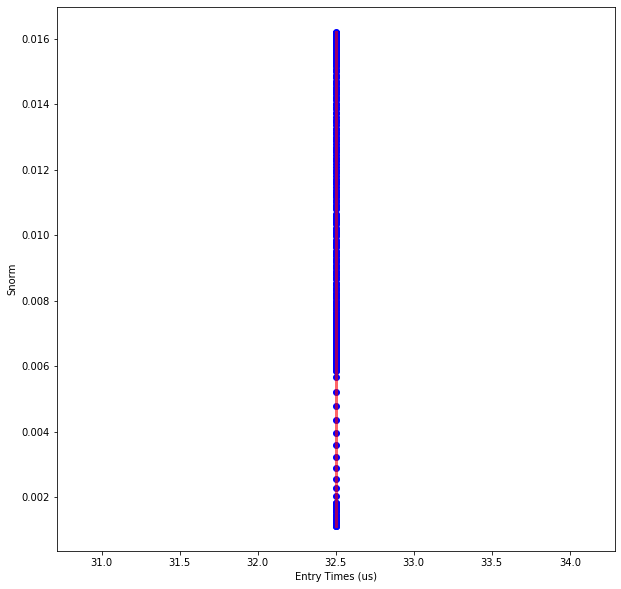

In [58]:
# Entry Time vs. S w/ Noise

# Same format as above

X_Val1 = [(n_pad_strt - 1) / 10, (n_pad_strt - 1) / 10] # Actual Variable Value of Track
Y_Val1 = [min(Snorm_data_plt_noise), max(Snorm_data_plt_noise)]

fig2 = plt.figure(figsize=[10,10])
plt.plot(tm_strt_plt_noise * 10**6, Snorm_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

#plt.xlim(t_entry * 10**6, t_entry * 10**6 + n_pad_strt / 10 + t_exit  * 10**6 + n_pad_end / 10) # Put ranges if necessary, careful of padding
plt.ylabel('Snorm')
plt.xlabel('Entry Times (us)')
plt.show()


 # of indices =  32 , fwhm =  7.4725321895799475
-----------------------------------------------------------


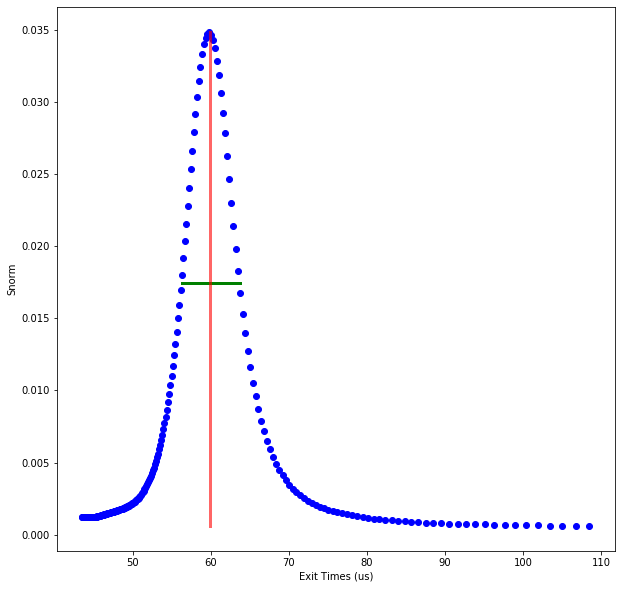

In [59]:
# Exit Time vs. S

X_Val1 = [(out[track]['time'][-1] + (n_pad_strt - (n_pad_end-1)) * 100) / 1000, (out[track]['time'][-1] + (n_pad_strt - (n_pad_end-1)) * 100) / 1000]
Y_Val1 = [min(Snorm_data_plt), max(Snorm_data_plt)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(tm_end_plt * 10**6, Snorm_data_plt, 'bo', alpha=1)

plt.plot([tm_end_plt[int(fwhm_data[2])] * 10**6, tm_end_plt[int(fwhm_data[3])] * 10**6], [hf_max_Snorm, hf_max_Snorm], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(tm_end_plt[int(fwhm_data[2])] - tm_end_plt[int(fwhm_data[3])]) * 10**6)
print('-----------------------------------------------------------')

plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)
plt.ylabel('Snorm')
plt.xlabel('Exit Times (us)')
plt.show()

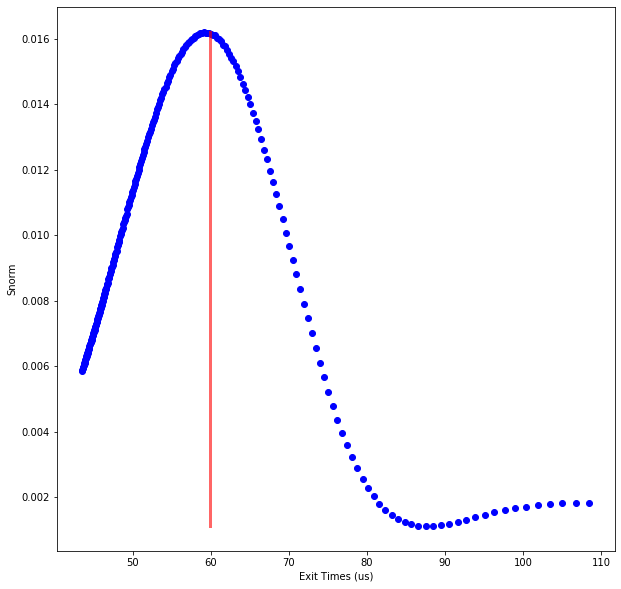

In [60]:
# Exit Time vs. S w/ Noise

X_Val1 = [(len(time) - n_pad_end)/10, (len(accels_noise[0]) - n_pad_end - lin_resp_len + 1)/10]
Y_Val1 = [min(Snorm_data_plt_noise), max(Snorm_data_plt_noise)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(tm_end_plt_noise * 10**6, Snorm_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('Snorm')
plt.xlabel('Exit Times (us)')
plt.show()

In [61]:
# Values of the Exit Time Analysis and Plotting

print(fwhm_data[2] * 10**(-7), tm_end_plt[int(fwhm_data[2])])
print(n_pad_strt + (np.argmax(transformed_data['S_norm'])))
print(t_exit / 100 - (n_pad_end + 1) + (n_pad_strt -1))

[6.04338765e-06] 6.379122854386603e-05
401
[37.00000027]



 # of indices =  32 , fwhm =  77.10843373493975
-----------------------------------------------------------


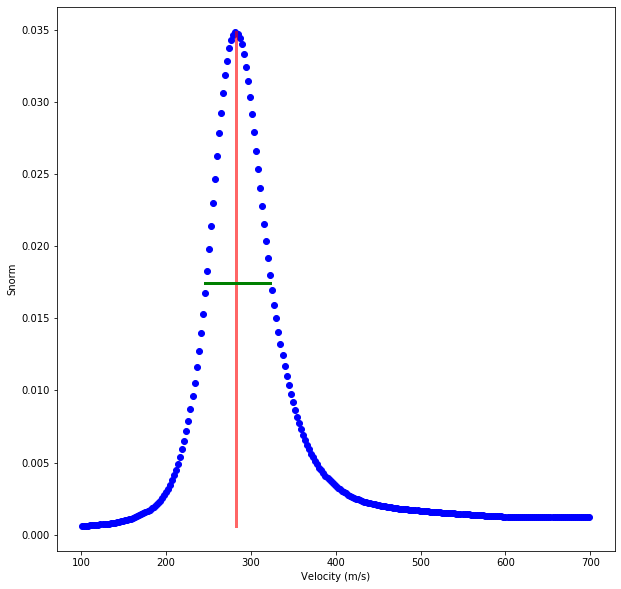

In [62]:
# Velocity vs. S

X_Val1 = [vel/1000, vel/1000]
Y_Val1 = [min(Snorm_data_plt), max(Snorm_data_plt)]

fig4 = plt.figure(figsize=[10,10])
plt.plot(vel_plt/1000, Snorm_data_plt, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

if 'Velocity' in analysis_parameter:
    vel_step = vel_plt[1] - vel_plt[0]
else:
    vel_step = 0

plt.plot([1e2 + fwhm_data[2] * vel_step / 1000, 1e2 + fwhm_data[3] * vel_step / 1000], [hf_max_Snorm, hf_max_Snorm], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(vel_plt[int(fwhm_data[2])] - vel_plt[int(fwhm_data[3])])/1000)
print('-----------------------------------------------------------')

plt.ylabel('Snorm')
plt.xlabel('Velocity (m/s)')
plt.show()

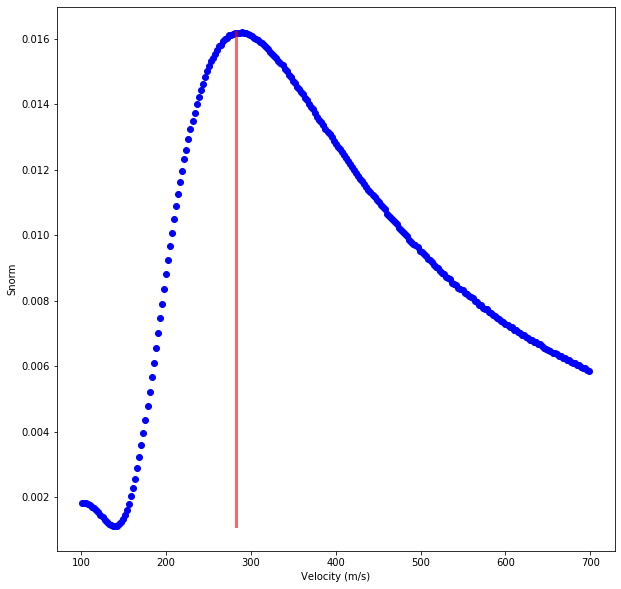

In [63]:
# Velocity vs. S w/ Noise

X_Val1 = [vel/1000, vel/1000]
Y_Val1 = [min(Snorm_data_plt_noise), max(Snorm_data_plt_noise)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(vel_plt_noise/1000, Snorm_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('Snorm')
plt.xlabel('Velocity (m/s)')
plt.show()

In [64]:
# Values of the Velocity Analysis and Plotting

print(fwhm_data[2] * vel_step / 1000, vel_plt[int(fwhm_data[2])] / 1000)
print(1e2 + (np.argmax(transformed_data['S_norm'])) * vel_step / 1000)
print(vel/1000)
print(vel_step/1000)

[145.6237988] 245.78313253012047
280.7228915662643
[283.]
2.4096385542168575



 # of indices =  32 , fwhm =  0.0
-----------------------------------------------------------


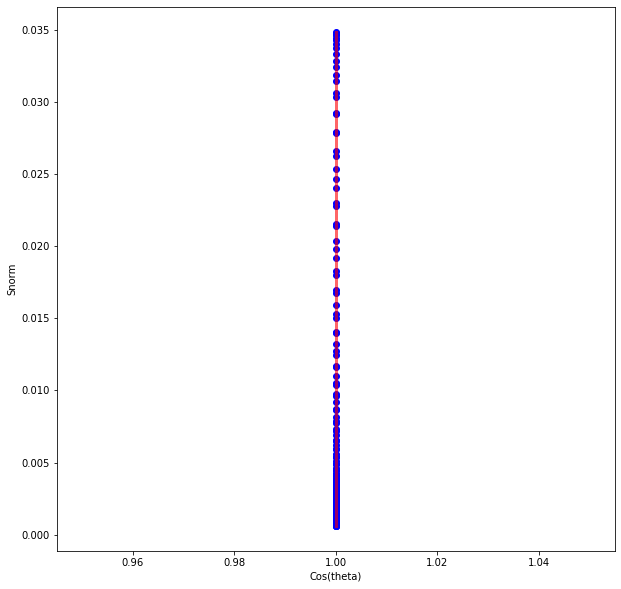

In [65]:
# cos(theta) vs. S

X_Val1 = [1, 1] # plotting cos theta values
Y_Val1 = [min(Snorm_data_plt), max(Snorm_data_plt)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(theta_cos_plt, Snorm_data_plt, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.plot([theta_cos_plt[int(fwhm_data[2])], theta_cos_plt[int(fwhm_data[3])]], [hf_max_Snorm, hf_max_Snorm], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(theta_cos_plt[int(fwhm_data[2])] - theta_cos_plt[int(fwhm_data[3])]))
print('-----------------------------------------------------------')

plt.ylabel('Snorm')
plt.xlabel('Cos(theta)')
plt.show()


 # of indices =  32 , fwhm =  0.0
-----------------------------------------------------------


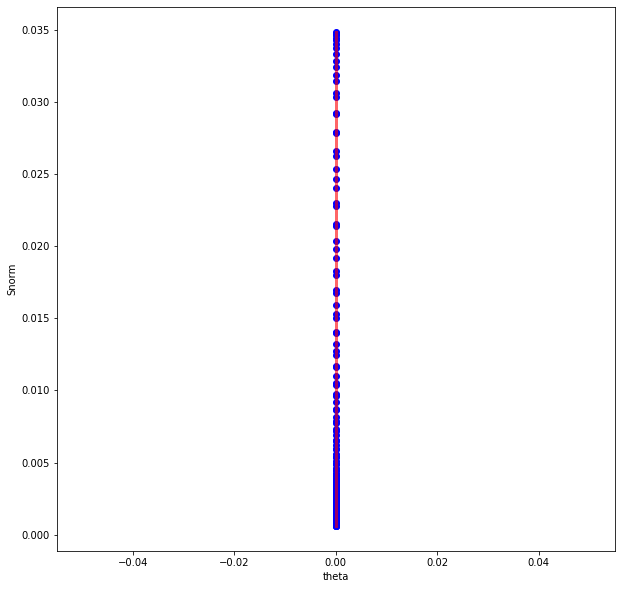

In [66]:
# Theta vs. S

X_Val1 = [0, 0] # plotting theta values
Y_Val1 = [min(Snorm_data_plt), max(Snorm_data_plt)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(theta_plt, Snorm_data_plt, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.plot([theta_plt[int(fwhm_data[2])], theta_plt[int(fwhm_data[3])]], [hf_max_Snorm, hf_max_Snorm], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(theta_plt[int(fwhm_data[2])] - theta_plt[int(fwhm_data[3])]))
print('-----------------------------------------------------------')

plt.ylabel('Snorm')
plt.xlabel('theta')
plt.show()

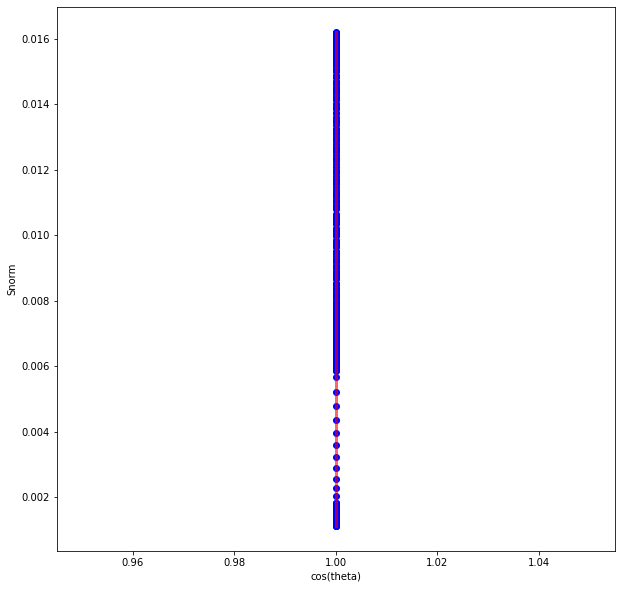

In [67]:
# cos(theta) vs. S or Theta vs. S w/ Noise

X_Val1 = [1, 1] # if plotting cos theta values
# X_Val1 = [0, 0] # if plotting theta values
Y_Val1 = [min(Snorm_data_plt_noise), max(Snorm_data_plt_noise)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(theta_cos_plt_noise, Snorm_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('Snorm')
plt.xlabel('cos(theta)')
plt.show()

In [68]:
timestep_indices = np.array(range(tmstep_strt, tmstep_end, tm_steps))
timesteps = time[timestep_indices]

if 'Velocity' in analysis_parameter:
    v_bin_edges = np.linspace(1e5, 7e5, 250)
else:
    v_bin_edges = vel

if len(timesteps) > 1:
    timestep_edges = list(timesteps-(timesteps[1]-timesteps[0])/2)
    timestep_edges.append(timesteps[-1] + (timesteps[1]-timesteps[0])/2)
    timestep_edges = np.array(timestep_edges)*1e-3
else:
    timestep_edges = np.array([timesteps[0] * 1e-3])

X, Y = np.meshgrid(timestep_edges, v_bin_edges)
C_norm = np.zeros(X.shape)
C = np.zeros(X.shape)

In [69]:
analysis_min_steps = 10
for i_row,row in enumerate(transformed_data):
    if row['steps'] > analysis_min_steps:
        j = np.searchsorted(timestep_edges, row['alpha1_t']*1e6) - 1
        #j = np.searchsorted(timestep_edges, row['alpha0_t']*1e6) - 1
        i = np.searchsorted(v_bin_edges, vel_plt[i_row]) - 1
        C[i,j] = row['S']
        C_norm[i,j] = row['S_norm']
    else:
        C[i,j] = 0
        C_norm[i,j] = 0

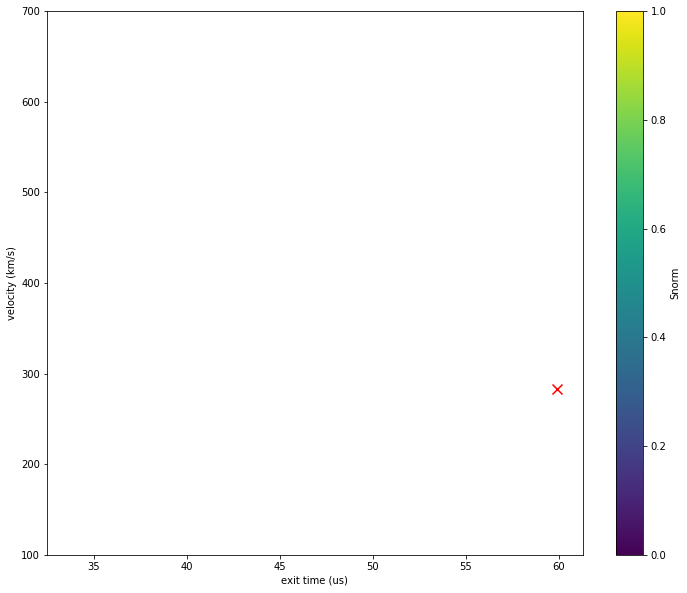

In [70]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
pcm = ax.pcolormesh(X,Y/1e3,C_norm)
#ax.scatter(n_pad_strt*0.1, vel[0]/1e3, c='red', marker='x', s=100)
ax.scatter((len(time) - n_pad_end)/10, vel[0]/1e3, c='red', marker='x', s=100)
#ax.set(xlabel='entry time (us)', ylabel='velocity (km/s)')
ax.set(xlabel='exit time (us)', ylabel='velocity (km/s)')
plt.colorbar(pcm, label='Snorm')
plt.show()